# Preprocessing bank marketing dataset

In [1]:
import pandas as pd
import sys
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None
from sklearn.model_selection import train_test_split

filename = r"E:\Documents\University of Hildesheim\Machine learning lab\lab5\bank.csv"
bank = pd.read_csv(filename,delimiter=';')

In [2]:
bank.dropna(inplace=True)

In [3]:
col=['job','marital','education','default','housing','loan','month','contact','duration','poutcome','y']
bank[col] = bank[col].astype('category')

In [4]:
bank_enc = bank.apply(lambda x: x.cat.codes if x.dtype.name == 'category' else x)

In [5]:
Ydata_bank = bank_enc['y'] 
Xdata_bank = bank_enc.loc[:,bank_enc.columns!='y']
Xdata_bank = (Xdata_bank - Xdata_bank.mean())/Xdata_bank.std() #data normalized

x_train_bank, x_test_bank, y_train_bank, y_test_bank =train_test_split(Xdata_bank, 
                                                                       Ydata_bank,train_size=0.8, 
                                                                       test_size=0.2, 
                                                                       random_state=0)

In [6]:
y_train_bank=pd.DataFrame(y_train_bank.values.reshape(-1,1))
y_test_bank=pd.DataFrame(y_test_bank.values.reshape(-1,1))
x_train_bank=pd.DataFrame(x_train_bank.values)
x_test_bank=pd.DataFrame(x_test_bank.values)

In [23]:
print('x_train_bank :',x_train_bank.shape)
print('x_test_bank :',x_test_bank.shape)
print('y_train_bank :',y_train_bank.shape)
print('y_test_bank :',y_test_bank.shape)

x_train_bank : (3616, 16)
x_test_bank : (905, 16)
y_train_bank : (3616, 1)
y_test_bank : (905, 1)


In [10]:
x_train_bank.shape

(3616, 16)

In [11]:
def logistic_function(X, beta):
    z = np.dot(X,beta)
    return 1 / (1 + np.exp(-z))

def log_likelihood(x, y, beta):
    z = np.dot(x, beta)
    log = np.sum( y*z - np.log(1 + np.exp(z)) )
    return log

betas = lambda x,y,beta,alpha,lamda : beta-alpha*(-2*np.dot(x.T,y-logistic_function(x, beta))+(2*lamda)*beta)
rmse  = lambda y,ypred: np.sqrt(np.mean((y-ypred)**2))
cost  = lambda y,ypred: np.mean((y - ypred)**2)

In [83]:
def stochastic_gradient_descent(x_train,y_train,alpha,epochs,lamda,x_test,y_test):
#     print('x_train_bank :',x_train.shape)
#     print('x_test_bank :',x_test.shape)
#     print('y_train_bank :',y_train.shape)
#     print('y_test_bank :',y_test.shape)
    
    m_train,n_features = np.shape(x_train)
    ini_alpha          = alpha
    beta_hat           = np.random.random(n_features).reshape(-1,1)
    rmsetrain          = []
    rmsetest           = []
    y_hat              = logistic_function(x_train,beta_hat)
    
    chunk_size = 50
    for i in range(epochs):
        for chunk in range(len(x_train)//chunk_size):
            x_chunk  = x_train[chunk*chunk_size:min((chunk+1)*chunk_size,len(x_train))]
            y_chunk  = y_train[chunk*chunk_size:min((chunk+1)*chunk_size,len(y_train))]
            
            beta_hat = betas(x_chunk,y_chunk,beta_hat,alpha,lamda)
        
        y_hat=logistic_function(x_train,beta_hat)
        
        rmsetest.append(rmse(y_test,logistic_function(x_test,beta_hat)))
        rmsetrain.append(rmse(y_train,logistic_function(x_train,beta_hat)))    
    return rmsetest,rmsetrain

# Hypertuning parameters tuning

### The function gridsearch is used to create the combinations of alpha and lamda
### The function data_k_divide is used to divide the dataset according to the number of k fold
### The function k_data_train_test is used to get random test and train data in every kfold

In [84]:
import math as Math

def gridsearch(alpha,lamda):
    comb=[]
    for i in range(0,len(alpha)):
        for k in range(0,len(lamda)):
            comb.append(dict([('alpha',alpha[i]),('lamda',lamda[k])]))
    return comb

def data_k_divide(data,k):
    k_size=Math.floor(len(data)/k)
    k_data=[] 
    c=0
    for i in range (0,k):
        data_set=pd.DataFrame(data.head(0))
        for j in range(i*k_size,(i*k_size)+k_size):
            data_set=data_set.append(data.iloc[j])
            c=c+1
        k_data.append(data_set)
        
    #adding datas which are remaining at the end of k division
    for j in range(c,len(data)):
        k_data[k-1]=k_data[k-1].append(data.iloc[j])
    return k_data

def k_data_train_test(x,y,k):
    k_folded_data=[]
    for i in range(0,k):
        x_test=x[i]
        y_test=y[i]
        x_train=pd.DataFrame()
        y_train=pd.DataFrame()
        for j in range(0,k):
            if i!=j:
                x_train=x_train.append(x[j])
                y_train=y_train.append(y[j])
        final_data=dict([('x',x_train),('y',y_train),('xt',x_test),('yt',y_test)])
        k_folded_data.append(final_data)
    return k_folded_data
    
def kfold(x_train,y_train,k,x_test,y_test):
    x_train_k=data_k_divide(x_train,k)
    y_train_k=data_k_divide(y_train,k)
    data=k_data_train_test(x_train_k,y_train_k,k)
    return data

### Hypertuning parameters  for bank marketing dataset
#### alpha_com and lamda_com is the array of all the alpha and lamda combinations
#### avg_rmse is the average of the last rmse for each k fold data

For every parameter combination the rmse train and rmse test is tracked

In [85]:
alpha=[0.0001,0.00001,0.001]
lamda=[0.0000001,0.1,0.5]
epochs=20
k=5
parameter=gridsearch(alpha,lamda)
rmse_test=[]
rmse_last=[]
rmse_train=[]
alpha_com=[]
lamda_com=[]
avg_rmse=[]
for i in range (0,len(parameter)):
    k_folded_data=kfold(x_train_bank,y_train_bank,k,x_test_bank,y_test_bank)
    for j in range(0,k):
            rmsetest,rmsetrain=stochastic_gradient_descent(k_folded_data[j]['x'],k_folded_data[j]['y'],parameter[i]['alpha'],epochs,parameter[i]['lamda'],k_folded_data[j]['xt'],k_folded_data[j]['yt'])
            rmse_last.append(rmsetest[-1])
            rmse_test.append(rmsetest)
            rmse_train.append(rmsetrain)
    alpha_com.append(parameter[i]['alpha'])
    lamda_com.append(parameter[i]['lamda'])
    avg_rmse.append(np.mean(rmse_last))

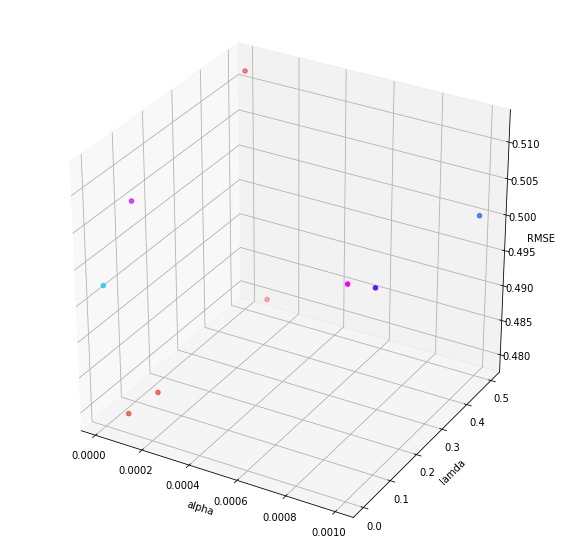

In [92]:
from mpl_toolkits import mplot3d
fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(10)
ax = plt.axes(projection= '3d')
ax.scatter3D(alpha_com, lamda_com, avg_rmse, c=avg_rmse, cmap='hsv')
ax.set_xlabel('alpha')
ax.set_ylabel('lamda')
ax.set_zlabel('RMSE')
plt.show()

### This function gets the optimal value of alpha and lamda by finiding out the index where avg_rmse is minimum 

In [113]:
def optimal_parameter(avg_rmse,alpha_com,lamda_com):
    lowest_rmse_index=avg_rmse.index(np.min(avg_rmse))
    opt_alpha=alpha_com[lowest_rmse_index]
    opt_lamda=lamda_com[lowest_rmse_index]
    return opt_alpha,opt_lamda

In [114]:
rmsetest=[]
rmsetrain=[]
epochs=50
alpha,lamda=optimal_parameter(avg_rmse,alpha_com,lamda_com)
rmsetest,rmsetrain=stochastic_gradient_descent(x_train_bank,y_train_bank,alpha,epochs,lamda,x_test_bank,y_test_bank)

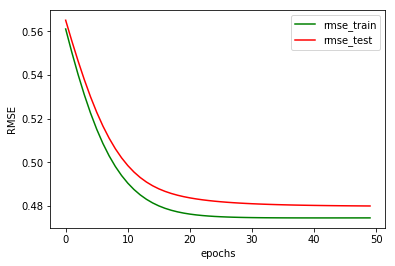

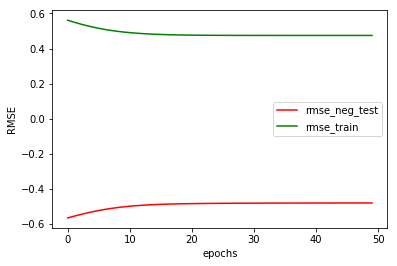

In [115]:
plt.plot(np.arange(len(rmsetrain)),rmsetrain,'g',label='rmse_train')
plt.plot(np.arange(len(rmsetest)),rmsetest,'r',label='rmse_test')
plt.xlabel("epochs")
plt.ylabel("RMSE")
plt.legend()
plt.show()
    
    
plt.xlabel("epochs")
plt.ylabel("RMSE")
rmsetest=[x*-1 for x in rmsetest]
plt.plot(np.arange(len(rmsetest)),rmsetest,'r',label='rmse_neg_test')
plt.plot(np.arange(len(rmsetrain)),rmsetrain,'g',label='rmse_train')
plt.legend()
plt.show()

### Hypertuning parameters for wine quality RED dataset

In [117]:
filename=r"E:\Documents\University of Hildesheim\Machine learning lab\lab5\winequality-red.csv"
rwine_data = pd.read_csv(filename,delimiter=';')
rwine_data.head(3)
Xdata_rwine = rwine_data.loc[:,rwine_data.columns!='quality']
Ydata_rwine = rwine_data[['quality']]
Xdata_rwine = (Xdata_rwine - Xdata_rwine.mean())/Xdata_rwine.std() #data normalized
x_train_rwine, x_test_rwine, y_train_rwine, y_test_rwine =train_test_split(Xdata_rwine, 
                                                                       Ydata_rwine,train_size=0.8, 
                                                                       test_size=0.2, 
                                                                       random_state=0)

y_train_rwine=pd.DataFrame(y_train_rwine.values.reshape(-1,1))
y_test_rwine=pd.DataFrame(y_test_rwine.values.reshape(-1,1))
x_train_rwine=pd.DataFrame(x_train_rwine.values)
x_test_rwine=pd.DataFrame(x_test_rwine.values)

In [133]:
print('x_train_bank :',x_train_rwine.shape)
print('x_test_bank :',x_test_rwine.shape)
print('y_train_bank :',y_train_rwine.shape)
print('y_test_bank :',y_test_rwine.shape)

x_train_bank : (1279, 11)
x_test_bank : (320, 11)
y_train_bank : (1279, 1)
y_test_bank : (320, 1)


In [168]:
alpha=[0.0001,0.00001,0.001]
lamda=[0.0000001,0.001,0.5]
epochs=20
k=5
parameter=gridsearch(alpha,lamda)
rmse_test=[]
rmse_last=[]
rmse_train=[]
alpha_com=[]
lamda_com=[]
avg_rmse=[]
for i in range (0,len(parameter)):
    k_folded_data=kfold(x_train_rwine,y_train_rwine,k,x_test_rwine,y_test_rwine)
    for j in range(0,k):
            rmsetest,rmsetrain=stochastic_gradient_descent(k_folded_data[j]['x'],k_folded_data[j]['y'],parameter[i]['alpha'],epochs,parameter[i]['lamda'],k_folded_data[j]['xt'],k_folded_data[j]['yt'])
            rmse_last.append(rmsetest[-1])
            rmse_test.append(rmsetest)
            rmse_train.append(rmsetrain)
    alpha_com.append(parameter[i]['alpha'])
    lamda_com.append(parameter[i]['lamda'])
    avg_rmse.append(np.mean(rmse_last))

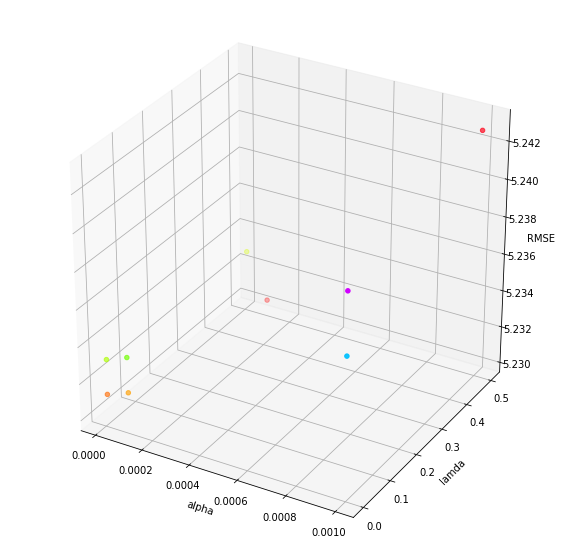

In [171]:
from mpl_toolkits import mplot3d
fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(10)
ax = plt.axes(projection= '3d')
ax.scatter3D(alpha_com, lamda_com, avg_rmse, c=avg_rmse, cmap='hsv')
ax.set_xlabel('alpha')
ax.set_ylabel('lamda')
ax.set_zlabel('RMSE')
plt.show()

OPTIMAL ALPHA : 1e-05
OPTIMAL LAMDA : 0.001


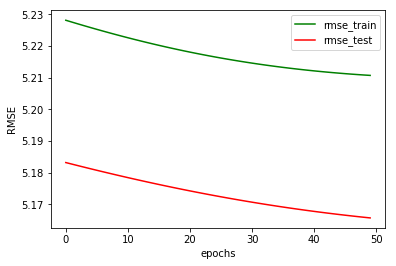

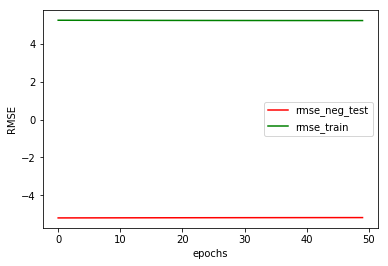

In [175]:
rmsetest=[]
rmsetrain=[]
epochs=50

alpha,lamda=optimal_parameter(avg_rmse,alpha_com,lamda_com)
print('OPTIMAL ALPHA :',alpha)
print('OPTIMAL LAMDA :',lamda)
rmsetest,rmsetrain=stochastic_gradient_descent(x_train_rwine,y_train_rwine,alpha,epochs,lamda,x_test_rwine,y_test_rwine)

plt.plot(np.arange(len(rmsetrain)),rmsetrain,'g',label='rmse_train')
plt.plot(np.arange(len(rmsetest)),rmsetest,'r',label='rmse_test')
plt.xlabel("epochs")
plt.ylabel("RMSE")
plt.legend()
plt.show()
    
    
plt.xlabel("epochs")
plt.ylabel("RMSE")
rmsetest=[x*-1 for x in rmsetest]
plt.plot(np.arange(len(rmsetest)),rmsetest,'r',label='rmse_neg_test')
plt.plot(np.arange(len(rmsetrain)),rmsetrain,'g',label='rmse_train')
plt.legend()
plt.show()

### Hypertuning parameters for wine quality WHITE dataset

In [161]:
filename=r"E:\Documents\University of Hildesheim\Machine learning lab\lab5\winequality-white.csv"
wwine_data = pd.read_csv(filename,delimiter=';')


Xdata_wwine = wwine_data.loc[:,wwine_data.columns!='quality']
Ydata_wwine = wwine_data['quality']
Xdata_wwine = (Xdata_wwine - Xdata_wwine.mean())/Xdata_wwine.std() #data normalized

x_train_wwine, x_test_wwine, y_train_wwine, y_test_wwine =train_test_split(Xdata_wwine, 
                                                                       Ydata_wwine,train_size=0.8, 
                                                                       test_size=0.2, 
                                                                       random_state=0)

y_train_wwine=pd.DataFrame(y_train_wwine.values.reshape(-1,1))
y_test_wwine=pd.DataFrame(y_test_wwine.values.reshape(-1,1))
x_train_wwine=pd.DataFrame(x_train_wwine.values)
x_test_wwine=pd.DataFrame(x_test_wwine.values)

In [162]:
alpha=[0.0000001,0.00001,0.001]
lamda=[0.0001,0.001,0.5]
epochs=20
k=5
parameter=gridsearch(alpha,lamda)
rmse_test=[]
rmse_last=[]
rmse_train=[]
alpha_com=[]
lamda_com=[]
avg_rmse=[]
for i in range (0,len(parameter)):
    k_folded_data=kfold(x_train_wwine,y_train_wwine,k,x_test_wwine,y_test_wwine)
    for j in range(0,k):
            rmsetest,rmsetrain=stochastic_gradient_descent(k_folded_data[j]['x'],k_folded_data[j]['y'],parameter[i]['alpha'],epochs,parameter[i]['lamda'],k_folded_data[j]['xt'],k_folded_data[j]['yt'])
            rmse_last.append(rmsetest[-1])
            rmse_test.append(rmsetest)
            rmse_train.append(rmsetrain)
    alpha_com.append(parameter[i]['alpha'])
    lamda_com.append(parameter[i]['lamda'])
    avg_rmse.append(np.mean(rmse_last))

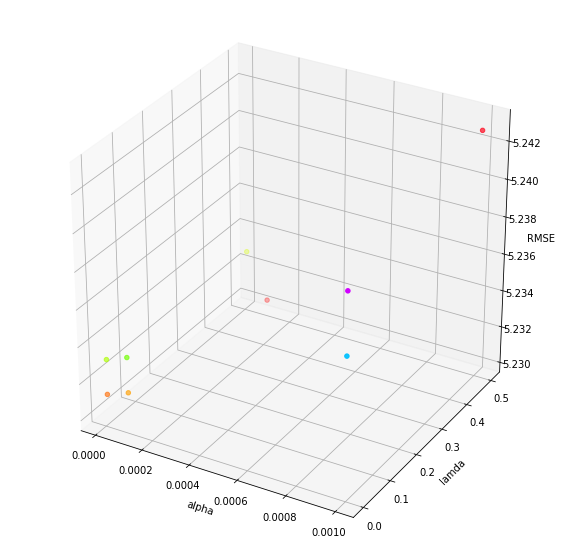

In [169]:
from mpl_toolkits import mplot3d
fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(10)
ax = plt.axes(projection= '3d')
ax.scatter3D(alpha_com, lamda_com, avg_rmse, c=avg_rmse, cmap='hsv')
ax.set_xlabel('alpha')
ax.set_ylabel('lamda')
ax.set_zlabel('RMSE')
plt.show()

OPTIMAL ALPHA : 0.0001
OPTIMAL LAMDA : 0.5


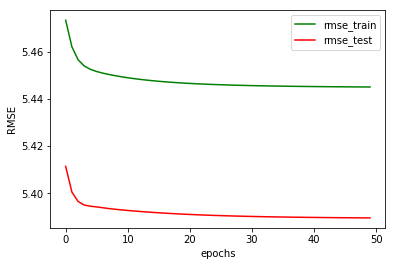

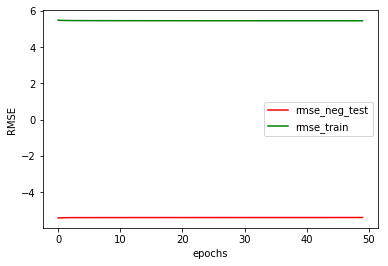

In [170]:
rmsetest=[]
rmsetrain=[]
epochs=50
alpha,lamda=optimal_parameter(avg_rmse,alpha_com,lamda_com)
print('OPTIMAL ALPHA :',alpha)
print('OPTIMAL LAMDA :',lamda)
rmsetest,rmsetrain=stochastic_gradient_descent(x_train_wwine,y_train_wwine,alpha,epochs,lamda,x_test_wwine,y_test_wwine)

plt.plot(np.arange(len(rmsetrain)),rmsetrain,'g',label='rmse_train')
plt.plot(np.arange(len(rmsetest)),rmsetest,'r',label='rmse_test')
plt.xlabel("epochs")
plt.ylabel("RMSE")
plt.legend()
plt.show()
    
    
plt.xlabel("epochs")
plt.ylabel("RMSE")
rmsetest=[x*-1 for x in rmsetest]
plt.plot(np.arange(len(rmsetest)),rmsetest,'r',label='rmse_neg_test')
plt.plot(np.arange(len(rmsetrain)),rmsetrain,'g',label='rmse_train')
plt.legend()
plt.show()